# RAMP: Predicting percentage of bleached corals from the GCBD

*Emeline Bruyère, Anaëlle Cossard, Alexis Michalowski-Skarbek, Rosanne Phebe, Rémi Poulard & Marine Tognia-tonou (M2 AMI2B).*  

<div>
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
    <td align="left"; style="background-color:transparent; width: 30%;">
        <a href="https://www.hi-paris.fr/">
            <img src="images/logo-hi-paris-retina.png" width="200px"/>
        </a>
    </td>
    <td align="center"; style="background-color:transparent; width:70%;">
        <a href="https://dataia.eu">
            <img src="images/DATAIA-h.png" width="600px"/>
        </a>
    </td>
    <td align="right"; style="background-color:transparent; width: 30%;">
        <a href="https://coralecologylab.wixsite.com/coralecologylab">
            <img src="images/Coral_reef_Ecology_lab_logo.png" width="200px"/>
        </a>
    </td>
  </tr>
 </table>
</div>



## Table of Contents
* [Introduction](#introduction)
* [The dataset](#dataset)
* [Requirements](#requirements)
* [Data exploration](#exploration)
* [Base model](#base_model)
* [Submitting on RAMP](#submitting)

## Introduction <a class="anchor" id="introduction"></a>
Coral reefs stand as some of the most diverse and vital ecosystems on the planet, playing an indispensable role in the health of our oceans. Approximately 25% of marine species rely on these vibrant underwater habitats for their survival. Central to the vitality of coral reefs is the intricate symbiotic relationship between corals and photosynthetic algae, which reside within their tissues. In this mutually beneficial partnership, corals provide protection and shelter to the algae, while receiving essential oxygen and nutrients in return.

However, when environmental stressors exert pressure on coral ecosystems, the delicate balance of this symbiosis can falter. This phenomenon, known as coral bleaching, manifests as the gradual breakdown of the relationship between corals and microalgae. Characterized by the loss of pigmentation and symbionts, bleached corals appear pale. Although coral bleaching can be temporary and reversible under certain conditions, prolonged stress can prove fatal for these fragile organisms.

Multiple factors contribute to coral bleaching, with global warming, human activities, and the prevalence of parasites and viruses among the primary culprits. Rising sea temperatures, in particular, have been closely linked to the increase in frequency and severity of coral bleaching events.

The Global Coral-Bleaching Database (GCBD) serves as a repository of invaluable information, compiling over three decades of coral bleaching records from around the world. With data spanning 93 countries and encompassing 14,405 sites, the GCBD offers crucial insights into the prevalence and distribution of coral bleaching. Key environmental parameters, such as site exposure, distance to land, mean turbidity, cyclone frequency, and various sea-surface temperature metrics, are meticulously documented within the database.

In light of the urgency to safeguard coral reef ecosystems, the objective of this RAMP challenge is to leverage the environmental data provided by the GCBD to predict the severity of the bleaching of corals.

For further exploration of coral reefs and their significance, please visit: [Coral Guardian](https://www.coralguardian.org/le-corail/)

| ![coral_reef.png](https://i.natgeofe.com/n/c17834a8-53ac-45ed-8f30-ede7698e1a8e/og-image-coral-before-after-better-hi-res-coral_16x9.jpg?w=1200) |
|:--:|
| <b>Contrasting States of Coral Reef Health: Vibrant Vitality vs. Bleached Extinction</b>|


## The dataset <a class="anchor" id="dataset"></a>
The description of all the columns of the dataset is available on [A global coral-bleaching database, 1980–2020](https://doi.org/10.1038/s41597-022-01121-y).

| ![dataset_structure.png](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41597-022-01121-y/MediaObjects/41597_2022_1121_Fig3_HTML.png?as=webp) |
|:--:|
| <b>Schematic of the Global Coral Bleaching Database (GCBD) showing the relationships among the 20 tables.</b>|

For this challenge, the data were first preprocessed and then split in order to preserve a private test set on which to evaluate the models on our servers. This leaves 4021 observations in the public train set and 3491 observations in the public test set. 
Observations are grouped by sites (with a Site_ID each) and we are very cautious to keep those examples from the same site either in the train set or in the test set (both during splitting and cross-validation).

Preprocessing steps before splitting the data:
1.  Collapsing of all the different database's table in one dataset
2.  Removing of empty columns, localisation columns (as it gives a biais on the bleaching) and time-series columns (as we wanted to keep the predicting task simple)
3.  Removing of outliers

## Requirements <a class="anchor" id="requirements"></a>
### Librairies

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score

## Data Exploration <a class="anchor" id="exploration"></a>

Let's start by getting the train data :

In [2]:
train_df = pd.read_csv('./data/public/train.csv',sep=';')
train_df = train_df.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1)

In [3]:
train_df.head()

,Sample_ID,Site_ID,ClimSST,Temperature_Kelvin,Temperature_Mean,Temperature_Minimum,Temperature_Maximum,Temperature_Kelvin_Standard_Deviation,Windspeed,SSTA,...,TSA_DHW_Standard_Deviation,TSA_DHWMax,TSA_DHWMean,Depth_m,Quadrat_No,Distance_to_Shore,Exposure,Turbidity,Cyclone_Frequency,Percent_Bleached
0,10274495,12082,301.65,303.50,299.79,293.35,305.54,2.52,2,0.49,...,0.74,6.05,0.22,8.3,NaN,8311.0,2,0.0586,56.583448,4.76
1,10274496,12083,299.31,300.84,299.75,293.68,305.44,2.54,6,-0.42,...,0.93,10.39,0.27,14.9,NaN,10747.0,2,0.0543,52.842523,21.88
2,10274497,12084,300.56,302.65,299.81,293.35,305.47,2.50,5,0.36,...,0.83,7.18,0.23,10.7,NaN,9396.0,2,0.0571,56.583448,19.66
3,10274498,12085,299.75,302.43,299.81,293.35,305.47,2.50,7,0.54,...,0.83,7.18,0.23,7.6,NaN,9408.0,2,0.0571,56.583448,28.03
4,10274499,12086,297.65,295.69,299.81,293.35,305.47,2.50,7,-0.91,...,0.83,7.18,0.23,10.0,NaN,9362.0,2,0.0571,56.583448,2.75


In [4]:
train_df.columns

Index(['Sample_ID', 'Site_ID', 'ClimSST', 'Temperature_Kelvin',
       'Temperature_Mean', 'Temperature_Minimum', 'Temperature_Maximum',
       'Temperature_Kelvin_Standard_Deviation', 'Windspeed', 'SSTA',
       'SSTA_Standard_Deviation', 'SSTA_Mean', 'SSTA_Minimum', 'SSTA_Maximum',
       'SSTA_Frequency', 'SSTA_Frequency_Standard_Deviation',
       'SSTA_FrequencyMax', 'SSTA_FrequencyMean', 'SSTA_DHW',
       'SSTA_DHW_Standard_Deviation', 'SSTA_DHWMax', 'SSTA_DHWMean', 'TSA',
       'TSA_Standard_Deviation', 'TSA_Minimum', 'TSA_Maximum', 'TSA_Mean',
       'TSA_Frequency', 'TSA_Frequency_Standard_Deviation', 'TSA_FrequencyMax',
       'TSA_FrequencyMean', 'TSA_DHW', 'TSA_DHW_Standard_Deviation',
       'TSA_DHWMax', 'TSA_DHWMean', 'Depth_m', 'Quadrat_No',
       'Distance_to_Shore', 'Exposure', 'Turbidity', 'Cyclone_Frequency',
       'Percent_Bleached'],
      dtype='object')

In [5]:
print('Number of samples : {}'.format(train_df.shape[0]))
print('Number of attributes : {}'.format(train_df.shape[1]))

Number of samples : 4021
Number of attributes : 42


We can see below that we don't have a lot of NA in our data except for 2 columns.

<Axes: >

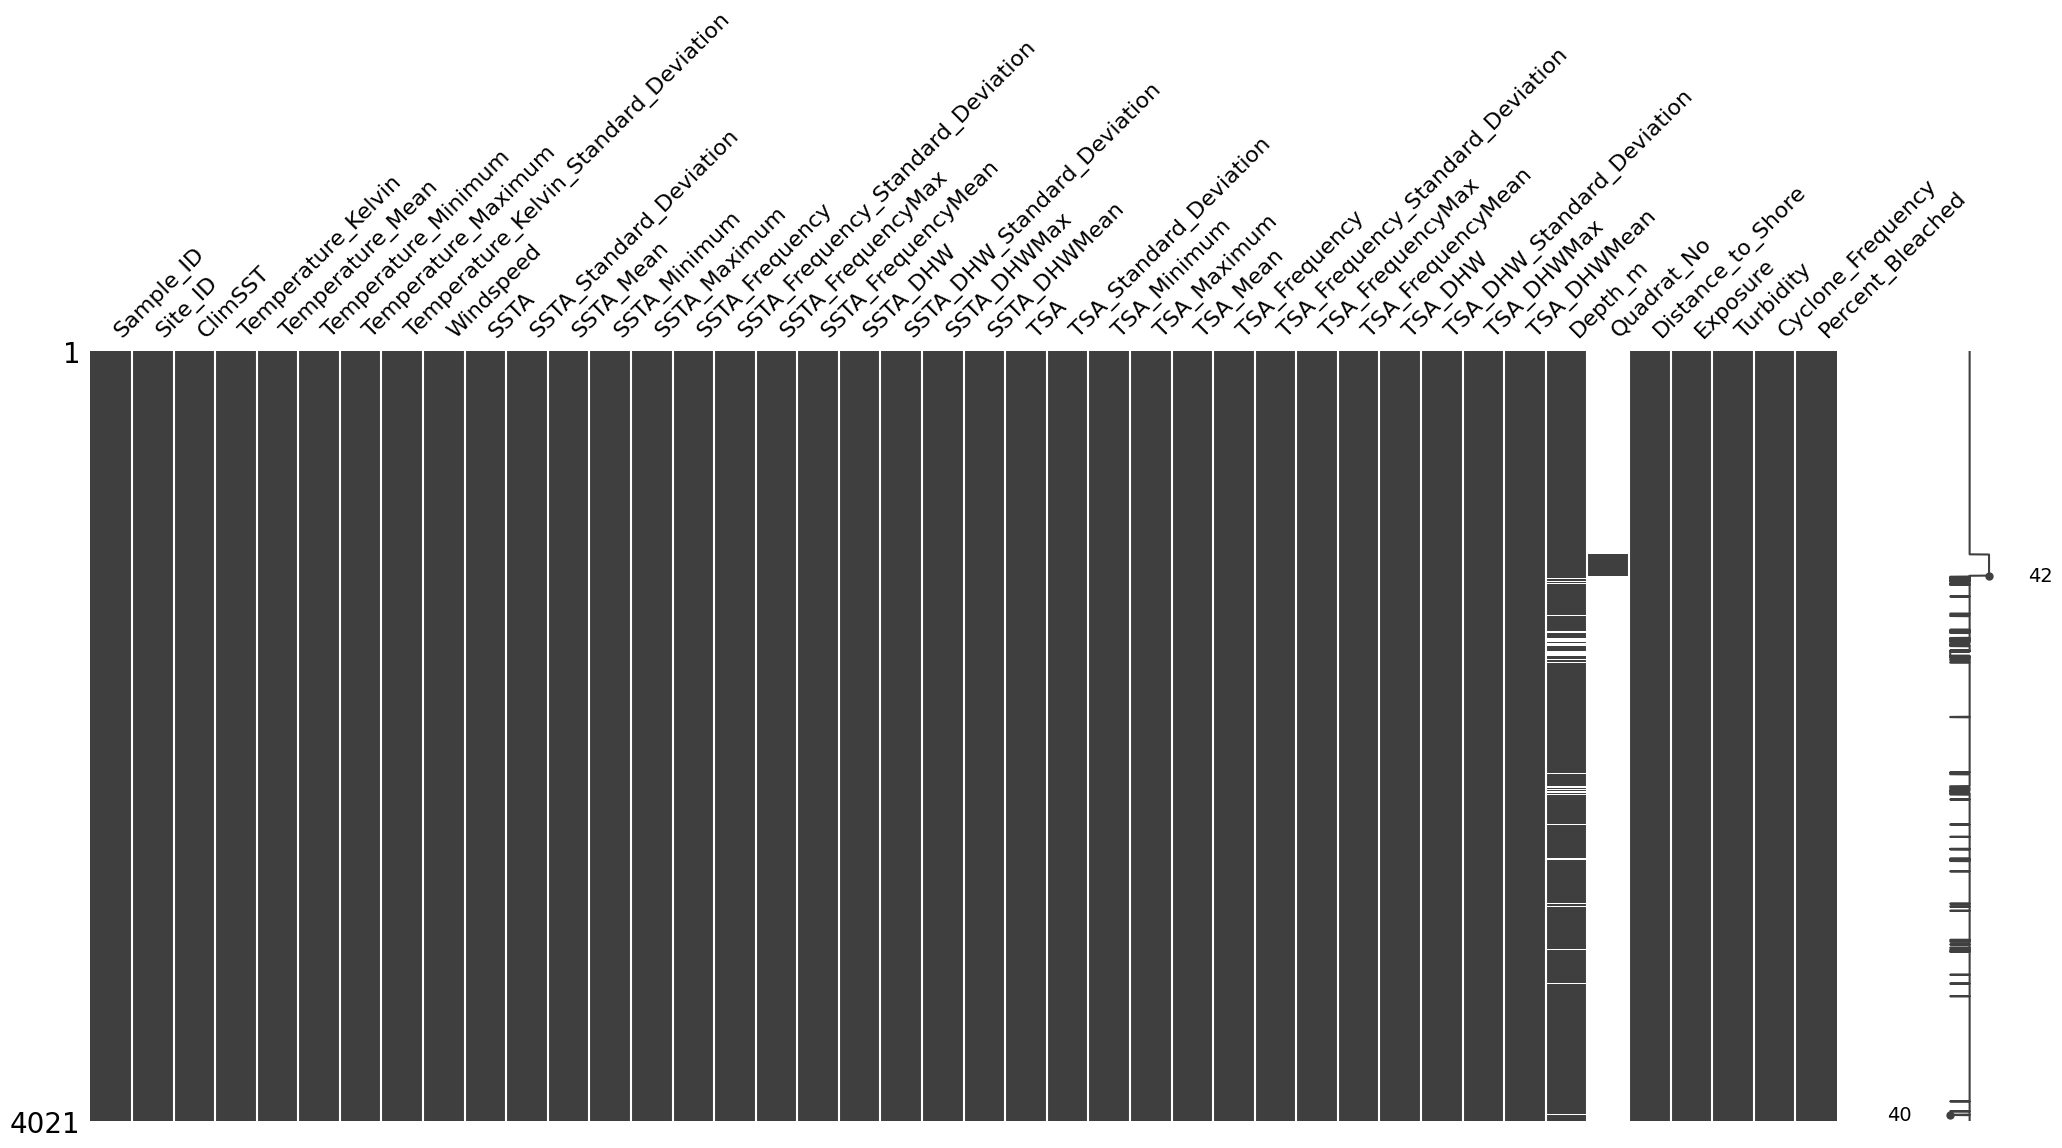

In [6]:
msno.matrix(train_df)

Let's take a look at the coral percentage of bleach, the target variable :

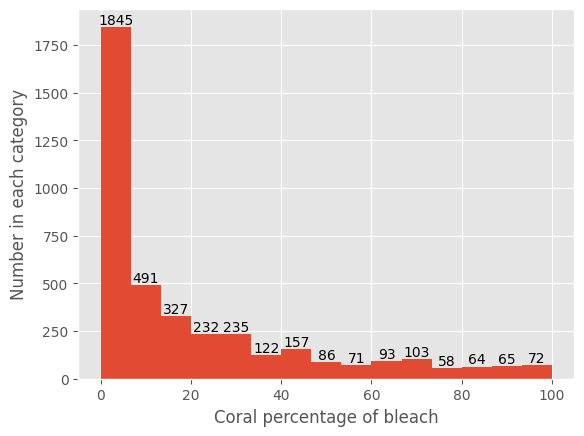

In [7]:
plt.style.use('ggplot')
counts, edges, bars = plt.hist(train_df.Percent_Bleached, bins=15)
plt.bar_label(bars)
        
plt.xlabel('Coral percentage of bleach')
plt.ylabel('Number in each category');

We can see that the majority of the counts are between 0% and 7%.

In [8]:
train_df.Percent_Bleached.value_counts(dropna=False, normalize=True).head(10)

Percent_Bleached
0.0      0.149963
100.0    0.010196
33.3     0.009948
10.0     0.009948
40.0     0.008207
20.0     0.006715
1.0      0.006217
5.0      0.005969
25.0     0.005720
70.0     0.005720
Name: proportion, dtype: float64

Let's now take a look at some other variables, such as temperature and SSTA. We can see that we have several columns giving different measures for each of them.

<Axes: >

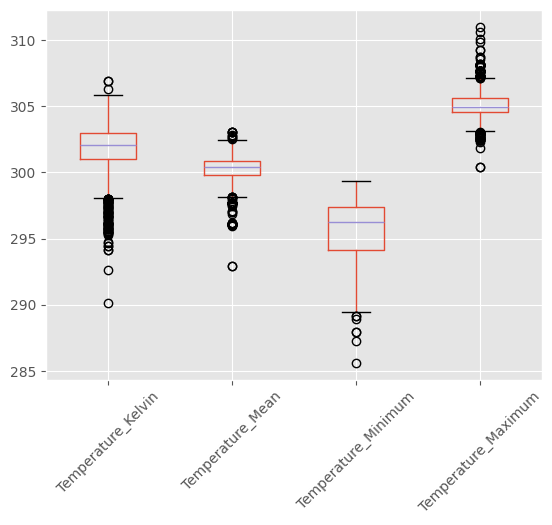

In [9]:
train_df.boxplot(column=['Temperature_Kelvin', 'Temperature_Mean', 'Temperature_Minimum','Temperature_Maximum'], rot = 45)

<Axes: >

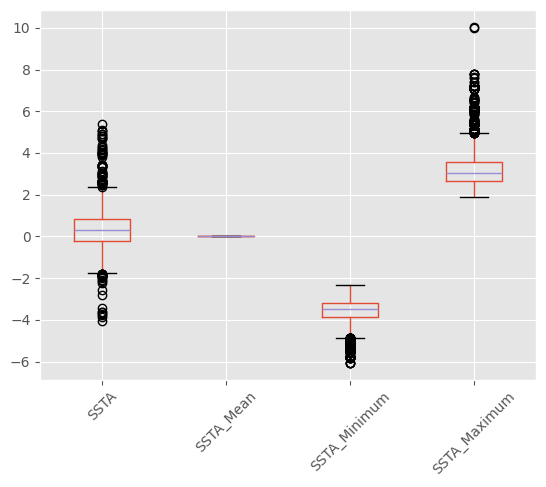

In [10]:
train_df.boxplot(column=['SSTA', 'SSTA_Mean', 'SSTA_Minimum','SSTA_Maximum'], rot = 45)

## Base model <a class="anchor" id="base_model"></a>

In [11]:
# We only keep The percent bleached data
train_df = pd.read_csv('./data/train.csv',sep=";")
train_df = train_df.iloc[:, 2:]

X_train_df = train_df.drop(['Percent_Bleached'], axis=1)
X_train_df

,Sample_ID,Site_ID,ClimSST,Temperature_Kelvin,Temperature_Mean,Temperature_Minimum,Temperature_Maximum,Temperature_Kelvin_Standard_Deviation,Windspeed,SSTA,...,TSA_DHW,TSA_DHW_Standard_Deviation,TSA_DHWMax,TSA_DHWMean,Depth_m,Quadrat_No,Distance_to_Shore,Exposure,Turbidity,Cyclone_Frequency
0,10274495,12082,301.65,303.500000,299.79,293.35,305.540000,2.520000,2,0.490000,...,1.27,0.740000,6.050000,0.220000,8.3,NaN,8311.00,2,0.058600,56.583448
1,10274496,12083,299.31,300.840000,299.75,293.68,305.440000,2.540000,6,-0.420000,...,1.20,0.930000,10.390000,0.270000,14.9,NaN,10747.00,2,0.054300,52.842523
2,10274497,12084,300.56,302.650000,299.81,293.35,305.470000,2.500000,5,0.360000,...,2.71,0.830000,7.180000,0.230000,10.7,NaN,9396.00,2,0.057100,56.583448
3,10274498,12085,299.75,302.430000,299.81,293.35,305.470000,2.500000,7,0.540000,...,3.60,0.830000,7.180000,0.230000,7.6,NaN,9408.00,2,0.057100,56.583448
4,10274499,12086,297.65,295.690000,299.81,293.35,305.470000,2.500000,7,-0.910000,...,0.00,0.830000,7.180000,0.230000,10.0,NaN,9362.00,2,0.057100,56.583448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4016,10331692,999767,299.63,299.330000,300.57,296.39,304.130000,1.130000,7,-0.110000,...,0.00,1.800000,13.370000,0.670000,11.5,NaN,1324.69,0,0.067133,46.836308
4017,10331693,999797,262.15,300.170000,300.58,296.66,304.371667,1.148333,8,0.413333,...,0.00,1.166667,9.181667,0.368333,7.8,NaN,1080.65,0,0.067133,46.836308
4018,10331694,999797,262.15,300.170000,300.58,296.66,304.371667,1.148333,8,0.413333,...,0.00,1.166667,9.181667,0.368333,7.9,NaN,1080.65,0,0.067133,46.836308
4019,10331699,999904,262.15,299.681667,300.58,296.66,304.371667,1.148333,7,-0.013333,...,0.00,1.166667,9.181667,0.368333,8.4,NaN,912.22,0,0.067133,46.836308


In [12]:
# We only keep The percent bleached data
test_df = pd.read_csv('./data/test.csv',sep=";")
test_df = test_df.iloc[:, 2:]

X_test_df = test_df.drop(['Percent_Bleached'], axis=1)
X_test_df

,Sample_ID,Site_ID,ClimSST,Temperature_Kelvin,Temperature_Mean,Temperature_Minimum,Temperature_Maximum,Temperature_Kelvin_Standard_Deviation,Windspeed,SSTA,...,TSA_DHW,TSA_DHW_Standard_Deviation,TSA_DHWMax,TSA_DHWMean,Depth_m,Quadrat_No,Distance_to_Shore,Exposure,Turbidity,Cyclone_Frequency
0,10274493,12080,300.900000,303.63,299.79,293.35,305.54,2.52,4,0.93,...,3.57,0.74,6.05,0.22,6.8,NaN,8686.00,2,0.057100,56.583448
1,10274494,12081,299.750000,302.43,299.81,293.35,305.47,2.50,7,0.54,...,3.60,0.83,7.18,0.23,9.8,NaN,9077.00,2,0.057100,56.583448
2,10274505,12089,298.610000,296.20,299.81,293.35,305.47,2.50,9,-0.68,...,0.00,0.83,7.18,0.23,5.0,NaN,9428.00,2,0.057100,56.583448
3,10274506,12090,297.650000,296.79,299.81,293.35,305.47,2.50,6,0.07,...,0.00,0.83,7.18,0.23,9.4,NaN,9139.49,2,0.057100,56.583448
4,10274507,12091,300.560000,302.65,299.81,293.35,305.47,2.50,5,0.36,...,2.71,0.83,7.18,0.23,5.8,NaN,9435.00,2,0.057100,56.583448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3486,10331698,999845,300.040000,299.55,300.65,296.39,304.29,1.15,10,-0.08,...,0.00,1.01,7.31,0.28,11.1,NaN,1585.59,0,0.067133,46.836308
3487,10331701,999906,283.202222,300.17,300.65,296.39,304.29,1.15,8,0.32,...,0.00,1.01,7.31,0.28,7.6,NaN,1044.93,0,0.058900,46.836308
3488,10331702,999906,283.202222,300.17,300.65,296.39,304.29,1.15,8,0.32,...,0.00,1.01,7.31,0.28,7.9,NaN,1044.93,0,0.058900,46.836308
3489,10331703,1000001,300.080000,299.14,300.65,296.39,304.29,1.15,7,-0.56,...,0.00,1.01,7.31,0.28,9.4,NaN,1812.58,0,0.067133,46.836308


In [13]:
X_train = X_train_df.to_numpy()
X_train

X_test = X_test_df.to_numpy()
X_test

#No Nan in the dataset

array([[1.02744930e+07, 1.20800000e+04, 3.00900000e+02, ...,
        2.00000000e+00, 5.71000000e-02, 5.65834480e+01],
       [1.02744940e+07, 1.20810000e+04, 2.99750000e+02, ...,
        2.00000000e+00, 5.71000000e-02, 5.65834480e+01],
       [1.02745050e+07, 1.20890000e+04, 2.98610000e+02, ...,
        2.00000000e+00, 5.71000000e-02, 5.65834480e+01],
       ...,
       [1.03317020e+07, 9.99906000e+05, 2.83202222e+02, ...,
        0.00000000e+00, 5.89000000e-02, 4.68363080e+01],
       [1.03317030e+07, 1.00000100e+06, 3.00080000e+02, ...,
        0.00000000e+00, 6.71333300e-02, 4.68363080e+01],
       [1.03317040e+07, 1.00000100e+06, 3.00080000e+02, ...,
        0.00000000e+00, 6.71333300e-02, 4.68363080e+01]])

In [14]:
y_train = train_df["Percent_Bleached"].astype('float64')
y_train, y_train.shape

(0        4.76
 1       21.88
 2       19.66
 3       28.03
 4        2.75
         ...  
 4016     0.00
 4017     0.00
 4018     0.00
 4019     0.00
 4020     0.00
 Name: Percent_Bleached, Length: 4021, dtype: float64,
 (4021,))

In [15]:
y_test = test_df["Percent_Bleached"].astype('float64')
y_test, y_test.shape

(0       35.48
 1       15.24
 2        1.15
 3        0.00
 4       19.14
         ...  
 3486     0.00
 3487     0.00
 3488     0.00
 3489     0.00
 3490     0.00
 Name: Percent_Bleached, Length: 3491, dtype: float64,
 (3491,))

In [16]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

In [17]:
regressor = Pipeline(
    steps=[
        ("transformer", numeric_transformer),
        ("regressor", LinearRegression())
    ]
)

In [18]:
regressor.fit(X_train, y_train)
regressor

Pipeline(steps=[('transformer',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('scaler', StandardScaler())])),
                ('regressor', LinearRegression())])

In [19]:
y_pred = regressor.predict(X_test)
y_pred.shape

(3491,)

MSE : A metric that tells us the average squared difference between the predicted values and the actual values in a dataset. The lower the MSE, the better a model fits a dataset.

In [20]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
variance = np.var(y_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
nrmse = rmse / np.std(y_test) # Avoid division by zero


print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')
print(f'Normalized Mean Squared Error (NMSE): {nrmse}')

Mean Squared Error (MSE): 409.52488240548035
Mean Absolute Error (MAE): 14.739879124729427
R-squared (R2): 0.397870009383404
Normalized Mean Squared Error (NMSE): 0.7759703542124505


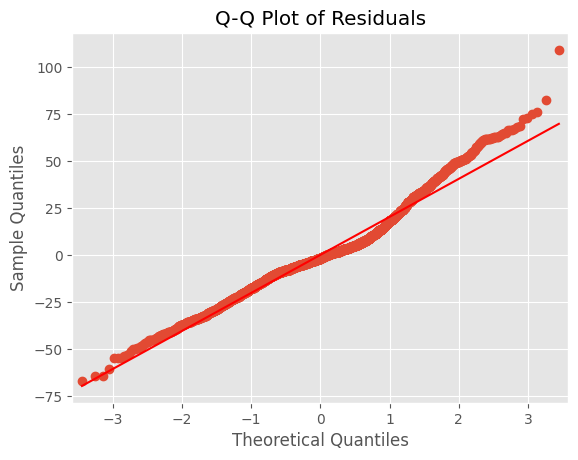

In [21]:
residuals = y_test - y_pred
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

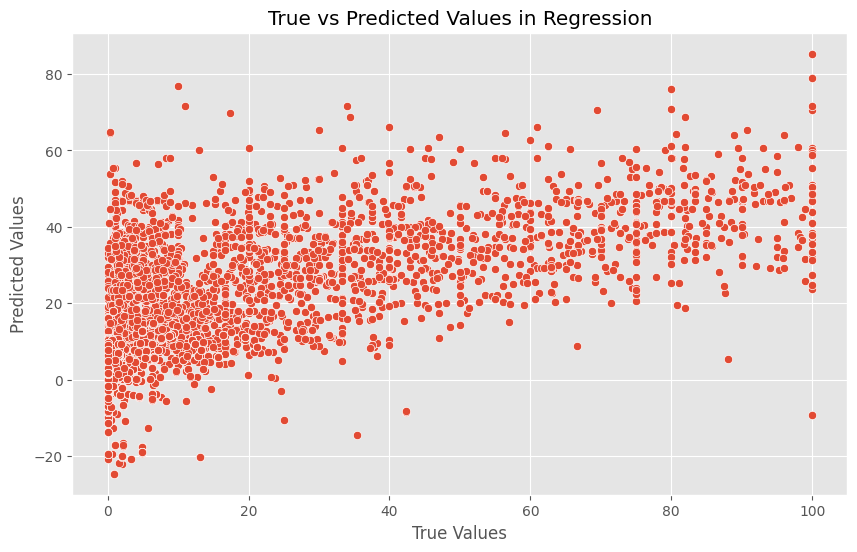

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.title('True vs Predicted Values in Regression')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

The Root Mean Squared error will be used as the leaderboard score. The lower the RMSE, the better a model fits a dataset.

In [24]:
rmse = mean_squared_error(y_test, y_pred, squared=False) 
rmse

20.23672113771103

This is the RMSE to beat in this challenge ! Good luck !

## Submitting to the online challenge: [ramp.studio](https://ramp.studio) <a class="anchor" id="submitting"></a>

Once you found a good model, you can submit them to [ramp.studio](https://www.ramp.studio) to enter the online challenge. If it is your first time using the RAMP platform, [sign up](https://www.ramp.studio/sign_up), otherwise [log in](https://www.ramp.studio/login). Then sign up to the event Coral bleaching. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your sandbox and copy-paste. You can also create a new folder `my_submission` in the `submissions` folder containing `regressor.py` and upload this file directly. You can check the starting-kit ([`regressor.py`](submissions/starting_kit/regressor.py)) for an example. The submission is trained and tested on our backend in the similar way as `ramp-test` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in **my submissions**. Once it is trained, your submission shows up on the public leaderboard. 
If there is an error (despite having tested your submission locally with `ramp-test`), it will show up in the "Failed submissions" table in **my submissions**. You can click on the error to see part of the trace.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, etc., _locally_, and checking them with `ramp-test`. The script prints mean cross-validation scores.

The official score in this RAMP (the first score column on the leaderboard) is the root mean squared error (`rmse`). When the score is good enough, you can submit it at the RAMP.

Here is the script proposed as the starting_kit:

In [25]:
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression  


class Regressor(BaseEstimator):
    def __init__(self):
        self.transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()),
            ]
        )
        self.model = LinearRegression()  
        self.pipe = make_pipeline(self.transformer, self.model)

    def fit(self, X, y):
        self.pipe.fit(X, y)

    def predict(self, X):
        return self.pipe.predict(X)

You can test your solution locally by running the ramp-test command followed by --submission <my_submission folder>.
Here is an example with the starting_kit submission:

In [26]:
!ramp-test --submission starting_kit

Testing Coral Bleaching Prediction
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
	score    rmse  Nrmse      time
	train  19.973  0.787  0.131219
	valid  20.856  0.813  0.011263
	test   20.701  0.794  0.009841
CV fold 1
	score    rmse  Nrmse      time
	train  20.196  0.786  0.104579
	valid  19.997  0.820  0.012584
	test   20.798  0.798  0.009884
CV fold 2
	score    rmse  Nrmse      time
	train  19.815  0.785  0.077840
	valid  21.466  0.822  0.022288
	test   20.723  0.795  0.025700
CV fold 3
	score    rmse  Nrmse      time
	train  19.961  0.795  0.085832
	valid  20.945  0.786  0.015908
	test   20.777  0.797  0.009182
CV fold 4
	score    rmse  Nrmse      time
	train  19.984  0.788  0.075417
	valid  20.854  0.812  0.011758
	test   20.842  0.799  0.009130
----------------------------
Mean CV scores
----------------------------
	score             rmse           Nrmse        time
	train  19.986 ± 0.1218  0.788 ± 0.0034  0.1 ± 0.02

## More information

See the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html) for more details.

## Questions

Questions related to the starting kit should be asked on the issue tracker.